In [1]:
from matplotlib import pyplot as plt
from pyppca import ppca
from sklearn import mixture
from sklearn.cluster import SpectralClustering
from operator import itemgetter
import os
from sklearn.decomposition import PCA
import numpy as np
import pickle
import sys
import pandas as pd
import scanpy as sc
from sklearn.metrics import *
data_folder_path = '../../../data'
sys.path.append(data_folder_path)
import matplotlib.patches as mpatches
import anndata as ad
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
import gpflow
float_type = gpflow.default_float()
import gpflux
from gpflow.config import default_float
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras import layers
sys.path.append('../../../mogp_decomposition/')
import mwgp as mwgp
from mwgp import GPD
import glob
from evaluation import *
from SEACells_MOGP import *

def get_free_gpu_idx():
    """Get the index of the GPU with current lowest memory usage."""
    os.system("nvidia-smi -q -d Memory |grep -A4 GPU|grep Used >tmp")
    memory_available = [int(x.split()[2]) for x in open("tmp", "r").readlines()]
    return np.argmin(memory_available)

gpu_idx = get_free_gpu_idx()
print("Using GPU #%s" % gpu_idx)
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_idx)

2024-06-24 10:20:01.554733: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-24 10:20:01.675032: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 10:20:04.062301: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using GPU #0


findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


Using GPU #0


## Evaluation 
#### The best result, associated with the 2D embedded MOGP with 500 epochs, is selected. We save its cell embedding and gene embedding for creating meta-cells and meta-genes in subsequent steps

In [2]:
import muon as mu
file_path = os.path.join(data_folder_path, 'CITEseq', 'pbmc5k_citeseq.h5mu')
mdata = mu.read(file_path)
mu.pp.intersect_obs(mdata)
rna = mdata.mod['rna']
rna = rna[:,rna.var.highly_variable]
prot = mdata.mod['prot']

col_dict1 = {'CD14 mono': '#8000ff',
                 'memory-like NK': '#5641fd',
                 'CD8+ naïve T': '#2c7ef7',
                 'pDC': '#00b5eb',
                 'CD16 mono': '#2adddd',
                 'intermediate mono': '#54f6cb',
                 'CD4+ naïve T': '#80ffb4',
                 'mature B': '#abf69b',
                 'CD4+ memory T': '#d4dd80',
                 'NK': '#ffb360',
                 'CD8+ memory T': '#ff7e41',
                 'pre-B': '#ff4121',
                 'Treg': '#ff0000',
                 None: '#CDC9C9'}
#This list defines the assigned cell type based on the top marker genes in rank_genes_groups    
cell_type_list1=['CD4+ naïve T','CD4+ memory T','intermediate mono','CD8+ memory T','CD14 mono',
                   'NK','intermediate mono','mature B','pre-B','memory-like NK','intermediate mono', 
                   'CD16 mono','Treg','CD8+ naïve T','pDC']
cell_type_list_modified1=cell_type_list1
rank_genes_groups=rna.uns["rank_genes_groups"]["names"]

#This list defines the assigned cell type based on the top marker prots in rank_prots_groups
cell_type_list2=['CD4+ naïve T', 'CD4+ memory T', 'Treg','CD8+ naïve T','CD8+ memory T','NK','memory-like NK',
               'pre-B','mature B', 'CD14 mono','intermediate mono','CD16 mono','pDC']
rank_prots_groups=prot.uns["rank_genes_groups"]["names"]
cell_type_list_modified2=['CD4+ naïve T', 'CD4+ memory T', 'Treg','CD8+ naïve T','CD8+ memory T','NK','memory-like NK',
                 'pre-B','mature B', 'CD14 mono','intermediate mono','CD16 mono','pDC']
        

/home/zmoslehi/miniconda3/envs/seaCell/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/zmoslehi/miniconda3/envs/seaCell/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/zmoslehi/miniconda3/envs/seaCell/lib/python3.9/site-packag

In [3]:
RNA_Normalized_2000 = (rna.X-np.mean(rna.X,0))/np.std(rna.X,0)

prot_Normalized_2000 = (prot.X-np.mean(prot.X,0))/np.std(prot.X,0)

In [4]:
np.random.seed(11111986)
[I,J] = RNA_Normalized_2000.shape
[I,K] = prot_Normalized_2000.shape

In [5]:
[i,j] = np.nonzero(RNA_Normalized_2000)
X_tr1 = []
for cnt in range(len(i)):
    X_tr1.append([i[cnt],j[cnt]])
X_tr1 = np.asarray(X_tr1)
Y_tr1 = RNA_Normalized_2000.ravel()
 

In [6]:
[i,j] = np.nonzero(prot_Normalized_2000)
X_tr2 = []
for cnt in range(len(i)):
    X_tr2.append([i[cnt],j[cnt]])
X_tr2 = np.asarray(X_tr2)
Y_tr2 = prot_Normalized_2000.ravel()
 

In [ ]:
dim1 = 2
dim2 = 2
dim3 = 2
num_epochs = 500
n_inducing_points1 = 512
n_inducing_points2 = 512
batch_size = 100000
with_PCA = 0
with_PPCA = 0
scale_emb1 = 0
scale_emb2 = 0
emb_reg = 0.001
lr = float(0.01)
kernel = ["RBF"]

if (with_PCA==0 or with_PPCA==0):
    title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
    save_path = './PBMC5KCITEseqMultiView-GPFlux  '+title+'/' 
    #save_path='./PBMC5KCITEseq2View-GPFlux  dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=500  emb_reg=0.001 with_PCA=0'
    hyper_params = {
    'I':I,
    'J':J,
    'K':K,    # the number of entities in each domain
    'M1': n_inducing_points1,                  # the number of inducing pairs
    'M2': n_inducing_points2,                  # the number of inducing pairs
    'emb_sizes': [dim1,dim2,dim3],      # the embedding sizes
    'batch_size':batch_size,      # the size of training batches
    'obs_mean1': Y_tr1.mean(),  # the mean of target
    'obs_mean2': Y_tr2.mean(),  # the mean of target
    'emb_reg': emb_reg,          # l2 norm on the embeddings
    'lr': lr,                # the learning rate 
    'save_path': save_path,        # path to save the trained models.
    }  
    
    gp_md = GPD(**hyper_params)
    gp_md.build(kernels=kernel)
    gp_md.load_model((X_tr1+1), (X_tr2+1))
    
    emb1 = gp_md.emb1
    embs1 = emb1((X_tr1+1)[0:-1:J,0])
    
    emb2 = gp_md.emb2
    embs2 = emb2((X_tr1+1)[0:J,1])
    
    emb3 = gp_md.emb3
    embs3 = emb3((X_tr2+1)[0:K,1])
 

In [ ]:
title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
save_path = './PBMC5KCITEseqMultiView-GPFlux  '+title+'/embs1.csv' 
file = open(save_path,'wb')
pickle.dump(embs1.numpy(),file)
file.close()

title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
save_path = './PBMC5KCITEseqMultiView-GPFlux  '+title+'/embs2.csv' 
file = open(save_path,'wb')
pickle.dump(embs2.numpy(),file)
file.close()

title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
save_path = './PBMC5KCITEseqMultiView-GPFlux  '+title+'/embs3.csv' 
file = open(save_path,'wb')
pickle.dump(embs3.numpy(),file)
file.close()


## Running SEACells
#### Consider that this part should run in seaCell environment created by  seaCell.yml file
#### We load the saved embedded cells and genes, then we provide the meta cells and meta genes provided by SEACells_compute function

#### 2D Cells

In [2]:
dim1 = 2
dim2 = 2
dim3 = 2
num_epochs = 500
n_inducing_points1 = 512
n_inducing_points2 = 512
batch_size = 100000
with_PCA = 0
with_PPCA = 0
scale_emb1 = 0
scale_emb2 = 0
emb_reg = 0.001
lr = float(0.01)
kernel = ["RBF"]

In [3]:
title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
save_path = './PBMC5KCITEseqMultiView-GPFlux  '+title+'/embs1.csv' 
file = open(save_path,'rb')
object_file = pickle.load(file)
file.close()

RNA_struct_MOGP = ad.AnnData(object_file)
RNA_struct_MOGP.obsm['X_umap']= object_file

Welcome to SEACells!
Computing kNN graph using scanpy NN ...


/home/zmoslehi/miniconda3/envs/seaCell/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/zmoslehi/miniconda3/envs/seaCell/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/zmoslehi/miniconda3/envs/seaCell/lib/python3.9/site-packag

Computing radius for adaptive bandwidth kernel...


  0%|          | 0/3891 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/3891 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/3891 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on X_umap
Computing diffusion components from X_umap for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 48 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|█████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 351.81it/s]

Selecting 12 cells from greedy initialization.


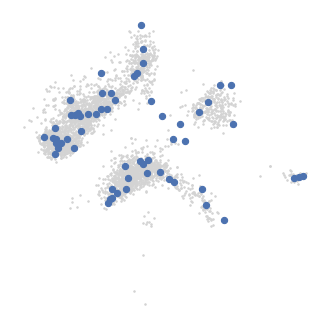

Randomly initialized A matrix.
Setting convergence threshold at 0.00120
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Converged after 34 iterations.
Ran for 35 iterations


findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

Ran for 40 iterations


findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.


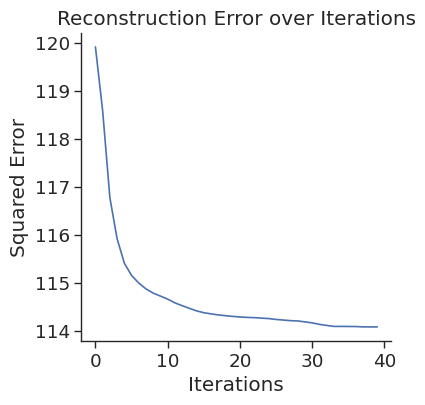

/home/zmoslehi/miniconda3/envs/seaCell/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/zmoslehi/miniconda3/envs/seaCell/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
find

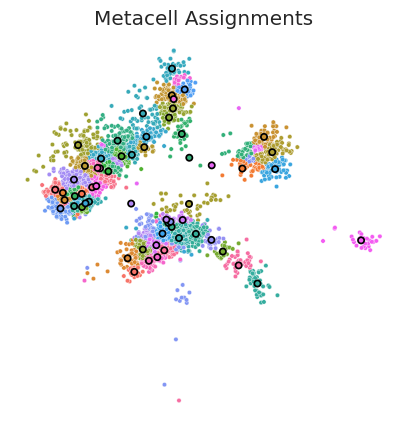

AnnData object with n_obs × n_vars = 3891 × 2
    obs: 'SEACell'
    uns: 'neighbors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [4]:
## User defined parameters

## Core parameters 
n_SEACells_cells = 60
build_kernel_on = 'X_umap' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells
RNA_struct_MOGP = SEACells_compute(RNA_struct_MOGP, n_SEACells_cells, build_kernel_on, n_waypoint_eigs)
RNA_struct_MOGP

In [12]:
title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
save_path = './PBMC5KCITEseqMultiView-GPFlux  '+title+'/'+'NumMetaCells='+str(n_SEACells_cells)+'seaCell_metaCells.csv' 
file = open(save_path,'wb')
pickle.dump(RNA_struct_MOGP.obs[['SEACell']],file)
file.close()

#### 2D Genes

In [5]:
dim1 = 2
dim2 = 2
dim3 = 2
num_epochs = 500
n_inducing_points1 = 512
n_inducing_points2 = 512
batch_size = 100000
with_PCA = 0
with_PPCA = 0
scale_emb1 = 0
scale_emb2 = 0
emb_reg = 0.001
lr = float(0.01)
kernel = ["RBF"]

In [6]:
title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
save_path = './PBMC5KCITEseqMultiView-GPFlux  '+title+'/embs2.csv' 
file = open(save_path,'rb')
object_file = pickle.load(file)
file.close()

Genes_struct_MOGP = ad.AnnData(object_file)
Genes_struct_MOGP.obsm['X_umap']= object_file

Welcome to SEACells!
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/1734 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/1734 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/1734 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on X_umap
Computing diffusion components from X_umap for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 52 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|█████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 756.08it/s]

Selecting 8 cells from greedy initialization.


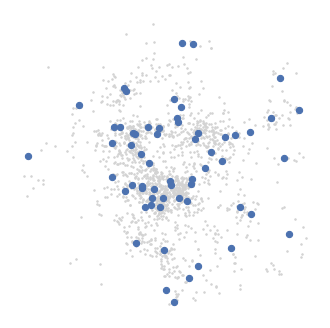

Randomly initialized A matrix.
Setting convergence threshold at 0.00074
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Converged after 35 iterations.
Ran for 36 iterations


findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

Ran for 41 iterations


findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.


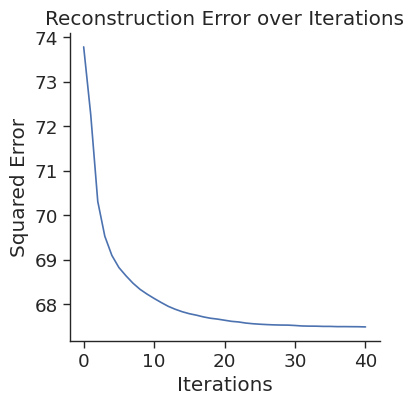

/home/zmoslehi/miniconda3/envs/seaCell/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/zmoslehi/miniconda3/envs/seaCell/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
find

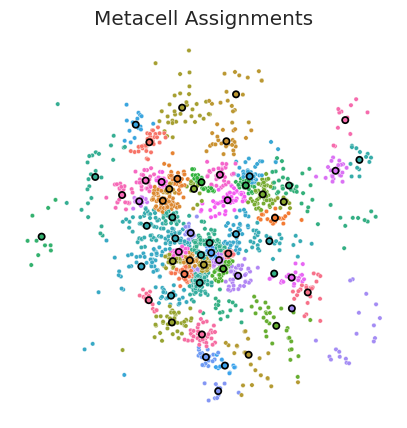

AnnData object with n_obs × n_vars = 1734 × 2
    obs: 'SEACell'
    uns: 'neighbors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [7]:
## User defined parameters

## Core parameters 
n_SEACells_genes = 120
build_kernel_on = 'X_umap' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells
Genes_struct_MOGP = SEACells_compute(Genes_struct_MOGP, n_SEACells_cells, build_kernel_on, n_waypoint_eigs)
Genes_struct_MOGP

In [12]:
title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
save_path = './PBMC5KCITEseqMultiView-GPFlux  '+title+'/'+'NumMetaCells='+str(n_SEACells_genes)+'seaCell_metaGenes.csv' 
file = open(save_path,'wb')
pickle.dump(Genes_struct_MOGP.obs[['SEACell']],file)
file.close()